In [1]:
import torch
import time
import gc
import os
import io
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
from copy import deepcopy 
from tabulate import tabulate
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import ConfusionMatrixDisplay
from collections import namedtuple
from collections import defaultdict as dd
import plotly.express as px
import chess
import chess.pgn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Dataset and model

In [2]:
class PGNProvider:
    
    def __init__(self, path : str, skip : int = 0):
        c = 0
        for line in open(path, "r"):
            if line == '\n':
                c += 1
        
        self.len = (c + 1) // 2
        self.read_count = 0
        self.pgn_file = open(path, "r")

        if skip >= self.len:
            raise Exception("Not enough games to skip")
        
        for _ in range(skip):
            while self.pgn_file.readline() != '\n': pass
            while self.pgn_file.readline() != '\n': pass
            self.len -= 1
    
    def __iter__(self):
        return self
    
    def __len__(self):
        return self.len
    
    def __next__(self):
        pgn_string = ""
        c = False

        while True:
            line = self.pgn_file.readline()
            
            if line == '':
                raise StopIteration
            
            if (c and line == '\n') or line == '':
                break
            elif line == '\n':
                c = True
            pgn_string += line   
        self.read_count += 1
        return pgn_string
    
    def __str__(self):
        return f"Read positions : {self.read_count} Limit : {self.limit} PGN file : {self.pgn_file}"

In [3]:
class BitboardDataset(Dataset):

    @classmethod
    def from_dataset_info(cls, dataset_info):
        return cls(dataset_info.source_file, dataset_info.chunk_size, dataset_info.shuffle, dataset_info.in_memory)
    
    def __init__(self, bitboard_file, chunk_size, shuffle = True, in_memory = False):
        self.curr_batch = 0
        self.shuffle = shuffle
        self.bitboard_file = bitboard_file
        self.chunk_size = chunk_size
        self.datasamples = self.calculate_dataset_size()
        
        self.batches = ceil(self.datasamples / chunk_size)
        self.splits = np.arange(chunk_size, self.datasamples, chunk_size)
        self.indices = np.arange(1, self.datasamples+1)
        self.splits = np.append(self.splits, [0])

        self.in_memory = in_memory or self.chunk_size == self.datasamples
        
        self.load_data()
    
    def __len__(self):
        return self.datasamples
        
    def __getitem__(self, idx):
        batch = idx // self.chunk_size
        # Laod new data 
        if self.curr_batch != batch and not self.in_memory:
            self.curr_batch = batch
            self.load_data()            

        idx -= self.chunk_size * self.curr_batch
        
        return self.bitboards[idx], self.is_draw[idx]
        
    def bitboards_to_layers(self, bitboards):
        cont = np.ascontiguousarray(np.expand_dims(bitboards.to_numpy(), 2)).view(np.uint8)
        return np.unpackbits(np.flip(cont, axis=2), axis=2).astype(np.single).reshape(-1, 768)

    def binary_features_to_layers(self, features):
        i = (features.to_numpy(dtype=np.uint64) - 1) ^ 0xffffffffffffffff
        cont = np.ascontiguousarray(np.expand_dims(i, 2)).view(np.uint8)
        return np.unpackbits(np.flip(cont, axis=2), axis=2).astype(np.single).reshape(-1, 768)

    def load_data(self):
        if self.curr_batch == 0 and self.shuffle:
            np.random.shuffle(self.indices)
            
        ignore = set(self.indices)

        if self.curr_batch == self.batches-1:
            ignore.difference_update(self.indices[self.splits[self.curr_batch-1]:])
        else:
            ignore.difference_update(self.indices[self.splits[self.curr_batch-1]:self.splits[self.curr_batch]])

        df = pd.read_csv(self.bitboard_file, skiprows=ignore)
        self.bitboards = self.bitboards_to_layers(df.iloc[:, range(12)].astype('uint64'))
        # self.meta_features = self.binary_features_to_layers(df[["white", "cK", "cQ", "ck", "cq"]])
        self.is_draw = df['draw'].to_numpy(dtype=np.single)

        # self.bitboards = np.hstack((self.bitboards, self.meta_features))
    
    def calculate_dataset_size(self):
        with open(self.bitboard_file) as f:
            return sum(1 for line in f) - 1

    def dataloader(self, batch_size):
        return DataLoader(self, batch_size=batch_size, shuffle=False, pin_memory=True)


In [4]:
class ConvolutionNetwork(nn.Module):

    def __init__(self, neurons=256):
        super().__init__()
        self.neurons = neurons
        self.model = nn.Sequential(
            nn.Unflatten(1, (12, 8, 8)),
            nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(1),
            
            nn.Linear(64 * 2 * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model.forward(x)

In [5]:
class DenseNetwork(nn.Module):

    def __init__(self, layers, sizes, normalization=False):
        super().__init__()
        self.sizes = sizes
        self.layers = layers
        ll = []

        assert self.layers == len(sizes) - 2, "Wrong layers to sizes number."
        
        for i in range(layers+1):
            ll.append(nn.Linear(self.sizes[i], self.sizes[i+1]))   
            if i < layers:
                if layers > 1 and normalization:
                    ll.append(nn.BatchNorm1d(self.sizes[i+1]))
                ll.append(nn.ReLU())
                
        self.model = nn.Sequential(*ll)

    def forward(self, x):
        return self.model.forward(x)

    def __str__(self):
        return f"Dense_{'_'.join(map(str, self.sizes))}"

# Evaluate positions morphe

In [6]:
class EvaluatePositions:

    def __init__(self, engine_path: str):
        self.engine = chess.engine.SimpleEngine.popen_uci(engine_path)
        
    def evaluate(self, board: chess.Board, limit: chess.engine.Limit):
        info = self.engine.analyse(board, limit)
        return info

    def is_draw(self, score):
        return -50 < score < 50


In [7]:
def count_pieces(board: chess.Board):
    result = 0
    for i in range(64):
        result += int(board.piece_at(i) is not None)
    return result

def evaluate_positions(dataset_path):
    results = dd(list)
    evaluator = EvaluatePositions('./morphebot')
    positions = pd.read_csv(dataset_path, usecols=['fen'])
    lpos = len(positions)
    try:
        with tqdm(total=lpos, position=0, leave=True, desc="Positions") as pbar:
 
            for index, row in positions.iterrows():
                tmp = dd(int)
                try: 
                    fen = row['fen']
                    board = chess.Board(fen)
                    
                    tmp['fen'] = fen
                    tmp['piece_count'] = count_pieces(board)
                    tmp['move'] = board.fullmove_number
                    for i in range(0, 12):
                        info = evaluator.evaluate(board, chess.engine.Limit(depth=i))
                        tmp[f'time{i}'] = info['time']
                        tmp['nodes'] = info['nodes']
                    
                except chess.InvalidMoveError:
                    print(f"Invalid move: {fen}")
                    evaluator = EvaluatePositions('./morphebot')
                    if len(tmp.keys()) != len(results.keys()):
                        tmp.clear()

                finally:
                    for key, val in tmp.items():
                        results[key].append(val)
                    pbar.update(1)
                    
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        pd.DataFrame(results).to_csv('data/stats/test.csv', index=False)
            
    return results

In [280]:
res = evaluate_positions('data/elite_dataset/bitboards/2000_20000.csv')

Positions:   0%|          | 0/2000 [00:00<?, ?it/s]

In [8]:
def get_all_data_files(data_dir):
    files = list(filter(lambda x: x.endswith(".csv"), os.listdir(data_dir)))
    return list(map(lambda x: data_dir + x, files))

def plot_evals(data_paths):
    data = pd.read_csv(data_paths[0])
    for i in range(1, len(data_paths)):
        newdata = pd.read_csv(data_paths[i])
        data = pd.concat([data, newdata], axis=0)

    mean = data.query("time11 < 20").groupby(["move"]).mean(numeric_only=True).filter(regex='^t', axis=1)
    piece_count = data.query("time11 < 20").groupby(["piece_count"]).mean(numeric_only=True).filter(regex='^t', axis=1)
    moves = data.groupby(["move"]).mean(numeric_only=True)['piece_count'].transpose()

    fig = px.line(mean, title="Time vs move number")
    fig.show()

    fig = px.line(moves, title="Moves vs piece count")
    fig.show()

    fig = px.line(piece_count, title="Time vs pieces count")
    fig.show()

    return mean, moves, piece_count


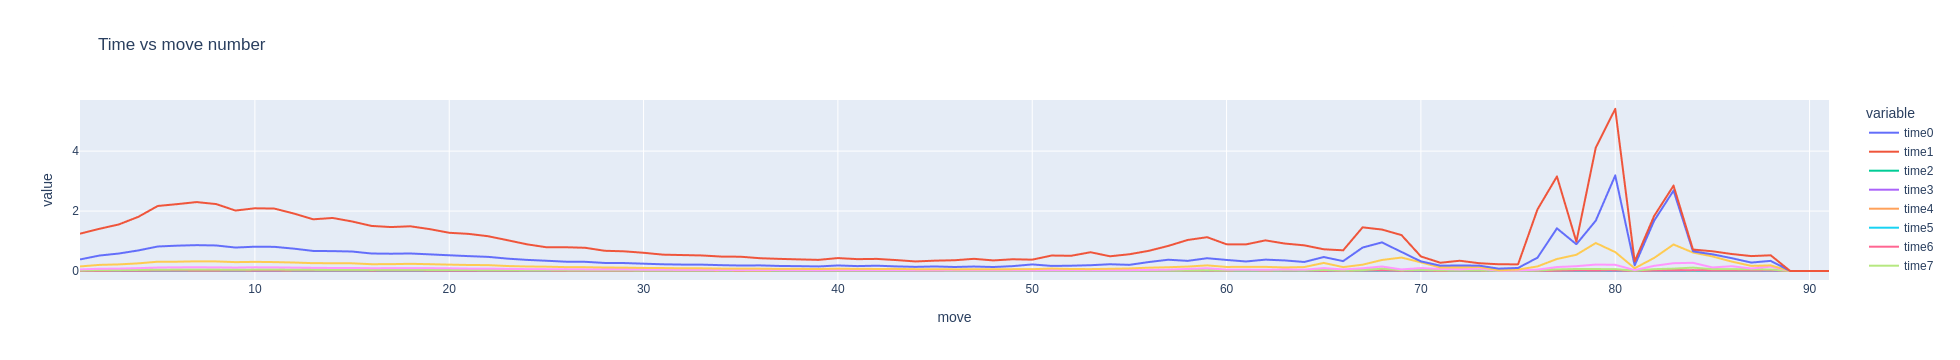

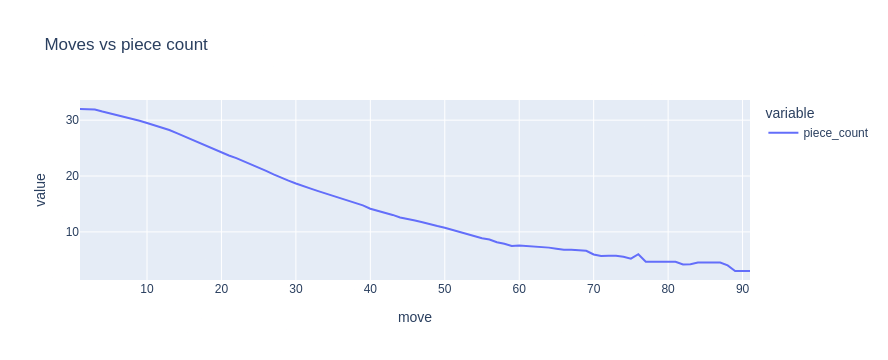

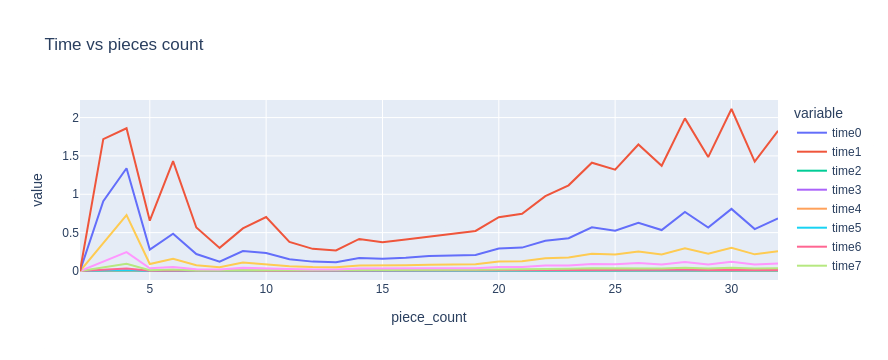

In [23]:
mean, moves, piece_count = plot_evals(get_all_data_files("data/stats/"))

In [36]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
(mean.to_numpy() * 1000).astype(np.uint32)

array([[   0,    0,    0,    0,    0,    2,    6,   20,   52,  152,  385,
        1245],
       [   0,    0,    0,    0,    0,    3,    9,   29,   74,  204,  515,
        1407],
       [   0,    0,    0,    0,    0,    4,   10,   30,   80,  219,  583,
        1554],
       [   0,    0,    0,    0,    1,    4,   12,   35,   95,  254,  685,
        1807],
       [   0,    0,    0,    0,    1,    5,   15,   42,  115,  310,  817,
        2169],
       [   0,    0,    0,    0,    1,    6,   16,   44,  122,  310,  845,
        2231],
       [   0,    0,    0,    0,    1,    6,   17,   44,  124,  323,  862,
        2299],
       [   0,    0,    0,    0,    1,    6,   17,   44,  121,  319,  852,
        2233],
       [   0,    0,    0,    0,    1,    5,   17,   42,  113,  296,  782,
        2017],
       [   0,    0,    0,    0,    2,    6,   18,   44,  123,  304,  811,
        2092],
       [   0,    0,    0,    0,    2,    6,   18,   45,  120,  297,  806,
        2083],
       [   0,    0,  

# Probability density

In [9]:
def pgn_to_bitboard(game) -> tuple[int]:
        result = []
        for side in chess.COLORS:
            for piece in chess.PIECE_TYPES:
                result.append(int(game.board().pieces(piece, side)))
        return tuple(result)

def generate_probability_density(model, dataset_path, prec=2):
    dataset = BitboardDataset(dataset_path, chunk_size=2000000, shuffle=False, in_memory=True)
    dataloader = dataset.dataloader(len(dataset))
    density = np.zeros(10**prec + 1)
    for x, _ in dataloader:
        model.to(device)
        model.eval()
        with torch.no_grad():
            pred = nn.functional.sigmoid(model(x)).cpu().numpy().astype(np.double)
            pred = (pred.flatten() * 10**prec).astype(np.int32)
            np.add.at(density, pred, 1)
        break
    
    return density
                

In [ ]:
### model = DenseNetwork(3, [768, 768, 256, 128, 1], normalization=True)
# model = DenseNetwork(2, [768, 256, 128, 1])
# model = DenseNetwork(1, [768, 768, 1])
model = DenseNetwork(0, [768, 1])
# model = DenseNetwork(5, [768, 768, 512, 256, 128, 64, 1])
model.load_state_dict(torch.load("models/5M/0l/Dense_768_1_b512_e2_lr0.00125_m0.9_acc63.26", map_location=device))
density = generate_probability_density(model, 'data/games_dataset/bitboards/133129_0.csv', prec=2)

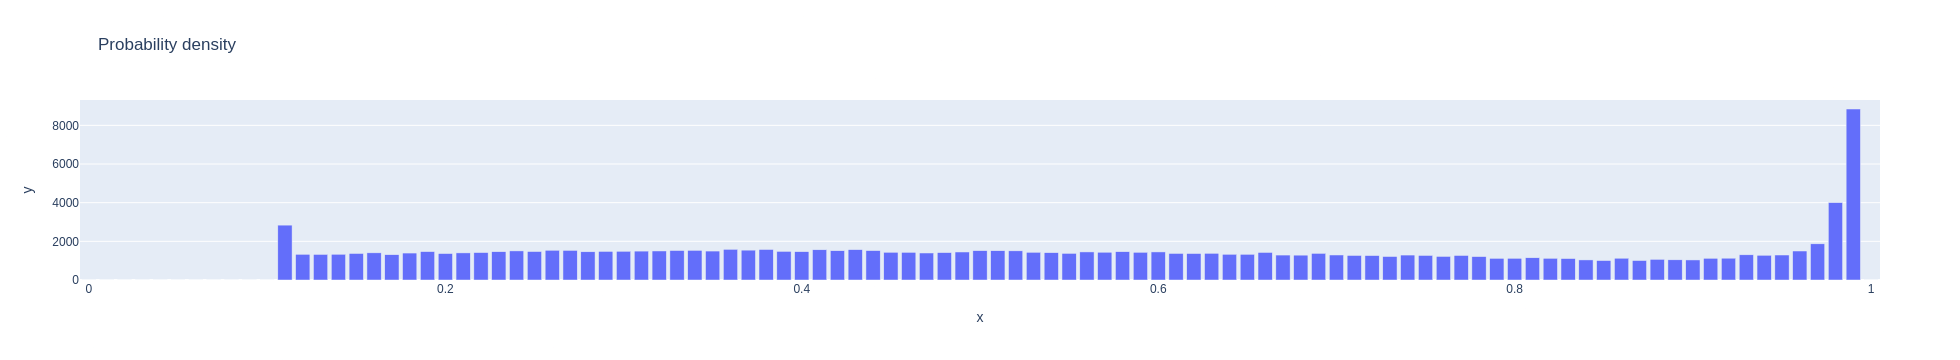

In [10]:
fig = px.bar(y=density, x=np.linspace(0, 1, 101), title="Probability density")
fig.show()

In [10]:
density.astype(np.uint32)

array([    0,     0,     2,     8,    38,   111,   181,   264,   401,
         572,   647,   761,   841,   921,   931,  1138,  1140,  1107,
        1287,  1323,  1330,  1391,  1427,  1444,  1502,  1529,  1499,
        1582,  1532,  1501,  1584,  1572,  1621,  1559,  1589,  1556,
        1612,  1529,  1570,  1585,  1515,  1466,  1555,  1491,  1589,
        1489,  1544,  1482,  1511,  1422,  1447,  1529,  1366,  1363,
        1440,  1385,  1352,  1331,  1267,  1332,  1263,  1266,  1269,
        1243,  1277,  1201,  1141,  1110,  1146,  1148,  1115,  1156,
        1093,  1055,  1085,  1087,  1158,  1070,  1088,  1082,  1078,
        1105,  1155,  1150,  1150,  1122,  1168,  1106,  1216,  1286,
        1308,  1359,  1435,  1489,  1618,  1753,  2060,  2515,  3603,
       10337,     0], dtype=uint32)

In [18]:
def to_rust_input(dataset_path):
    dataset = BitboardDataset(dataset_path, chunk_size=2000000, shuffle=False, in_memory=True)
    dataloader = dataset.dataloader(len(dataset))

    for x, y in dataloader:
        data = pd.DataFrame(x.numpy().astype(np.uint8))
        data.to_csv('rust_in.csv', header=False, index=False)

In [29]:
np.set_printoptions(threshold=10000)
# to_rust_input('data/games_dataset/bitboards/12696_0_0_0.csv')

# Plots

In [2]:
def conf_matrix(y_true, preds):
    y_true = np.bitwise_xor(y_true, 1)
    preds  = np.bitwise_xor(preds, 1)
    
    t = preds & y_true
    f = t^1
    
    po = preds & 1
    pz = po^1
    
    to = y_true & 1
    tz = to^1

    a = (pz & tz).sum(axis=1)
    b = (po & tz).sum(axis=1)
    c = (pz & to).sum(axis=1)
    d = (po & to).sum(axis=1)
    return np.column_stack((a,b,c,d)).reshape(-1, 2, 2)
    
def precision_score(conf_mat):
    return conf_mat[:, 1, 1] / (conf_mat[:, 1, 1] + conf_mat[:, 0, 1])

def recall_score(conf_mat):
    return conf_mat[:, 1, 1] / (conf_mat[:, 1, 1] + conf_mat[:, 1, 0])


def test_model(model, validate_dataloader):
    SAMPLE_NUM = 99
    samples = np.linspace(0.01, 0.99, SAMPLE_NUM)
    
    model.to(device)
    model.eval()
    with torch.no_grad():   
        acc, loss = 0, 0
        conf_mat = np.zeros((SAMPLE_NUM, 2, 2))
        for i, (x, y_true) in enumerate(validate_dataloader):
            x, y_true = x.to(device), y_true.unsqueeze(1).to(device)
            voutputs = model(x)
            loss += nn.functional.binary_cross_entropy_with_logits(voutputs, y_true) 
            out = nn.functional.sigmoid(voutputs).cpu().numpy()
    
            y_true = y_true.cpu().numpy().astype(np.int8)
            preds = np.array([out > k for k in samples]).astype(np.int8)
            
            acc += (preds == y_true).sum(axis=1)
            conf_mat += conf_matrix(y_true, preds)
    
    conf_mat = conf_mat
    acc = (acc / len(validate_dataset) * 100).squeeze()
    loss = (loss / (i+1)).cpu().numpy()
    prec =  precision_score(conf_mat) * 100
    recall = recall_score(conf_mat)
    
    best_acc = np.argmax(acc)
    best_prec = np.nanargmax(prec)

    print(f"Loss: {loss}")
    print(f"Acc: {acc[best_acc]}%")
    print(f"Precision: {prec[best_acc]}")
    print(f"Recall: {recall[best_acc]}")
    
    fig = px.line(x=samples, y=acc, title="Accuracy")
    fig.show()
    fig = px.line(x=samples, y=prec, title="Precision")
    fig.show()

    ConfusionMatrixDisplay(conf_mat[best_acc].astype(np.int32)).plot(cmap='Oranges')
    ConfusionMatrixDisplay(conf_mat[best_prec].astype(np.int32)).plot(cmap='Oranges')

## 0 hidden layers

Loss: 0.6224418878555298
Acc: 65.509%
Precision: 62.894430326133
Recall: 0.5371329098184613


/tmp/ipykernel_3359/1241753206.py:18: RuntimeWarning:

invalid value encountered in divide



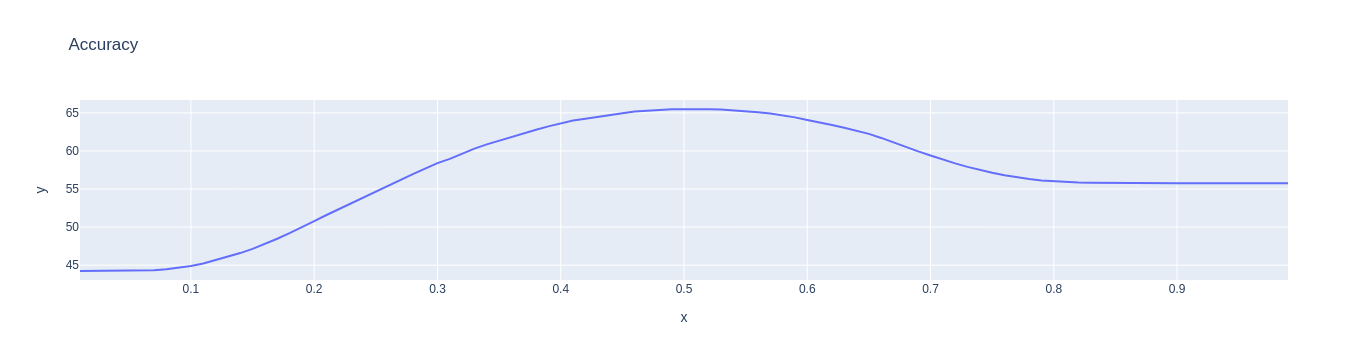

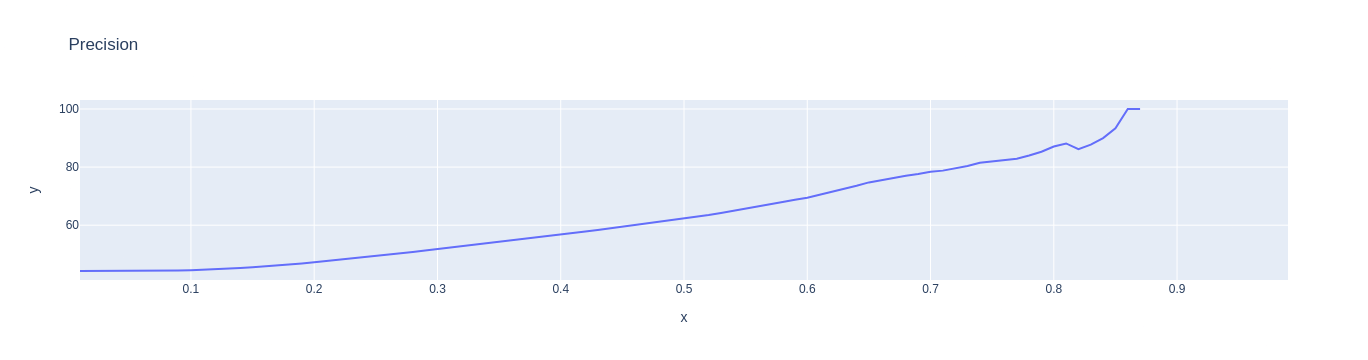

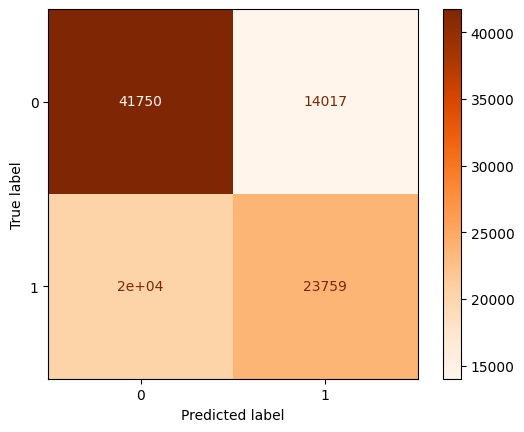

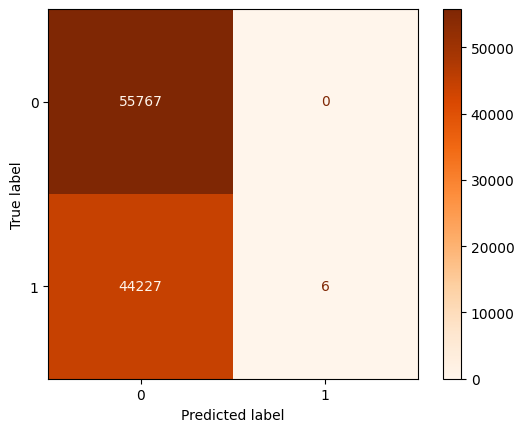

In [13]:
validate_dataset = BitboardDataset("data/eval_dataset/bitboards/100000_1509579_19_24.csv", chunk_size=100000, shuffle=False)
validate_dataloader = DataLoader(validate_dataset, batch_size=512)

model = DenseNetwork(0, [768, 1])
model.load_state_dict(torch.load("models/1M/0l/Dense_768_1_b512_e42_lr0.01_m0.9_acc65.25", map_location=device))

test_model(model, validate_dataloader)

## 1 hidden layer

Loss: 0.9046630859375
Acc: 63.457999384056066%
Precision: 33.095238095238095
Recall: 0.002865624871149961


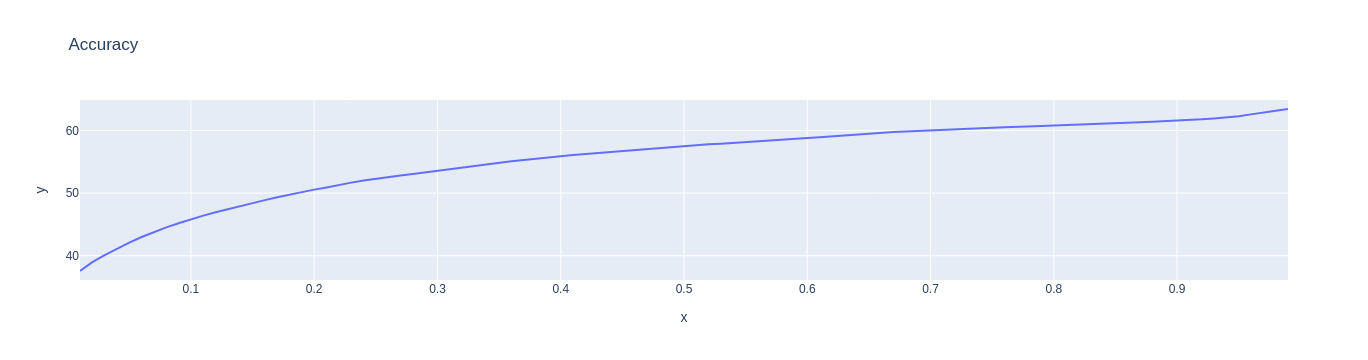

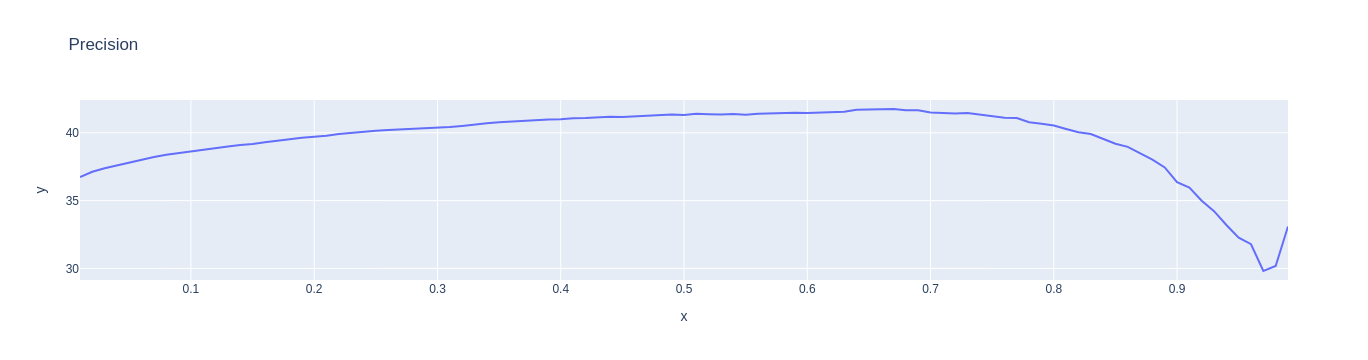

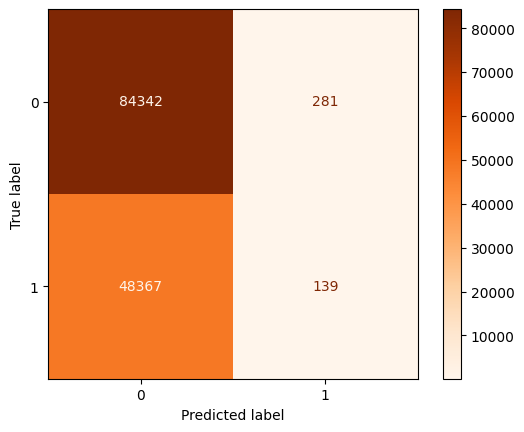

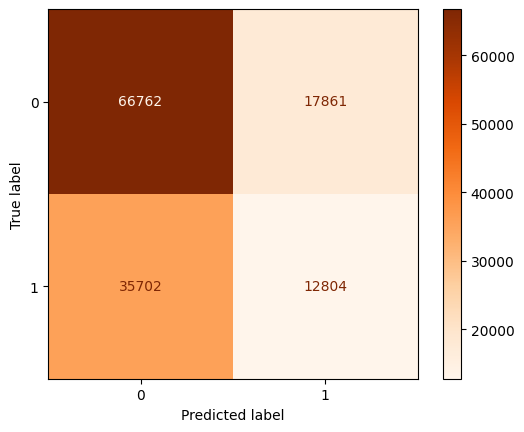

In [20]:
validate_dataset = BitboardDataset("data/games_dataset/bitboards/133129_0.csv", chunk_size=100000, shuffle=False)
validate_dataloader = DataLoader(validate_dataset, batch_size=512)

model = DenseNetwork(1, [768, 768, 1])
model.load_state_dict(torch.load("models/1M/1l/Dense_768_768_1_b512_e49_lr0.01_m0.9_acc83.15", map_location=device))

test_model(model, validate_dataloader)

Loss: 1.481123447418213
Acc: 55.49053925140277%
Precision: 60.72606423461363
Recall: 0.848599080628198


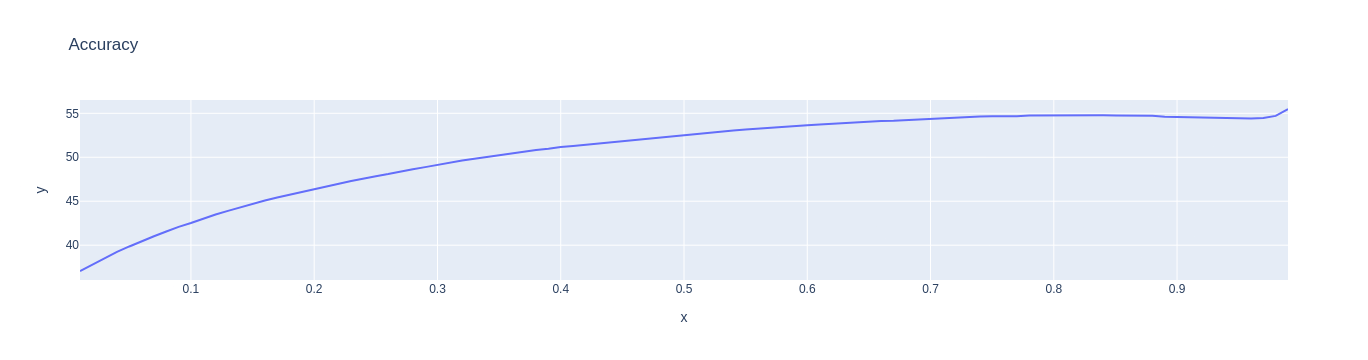

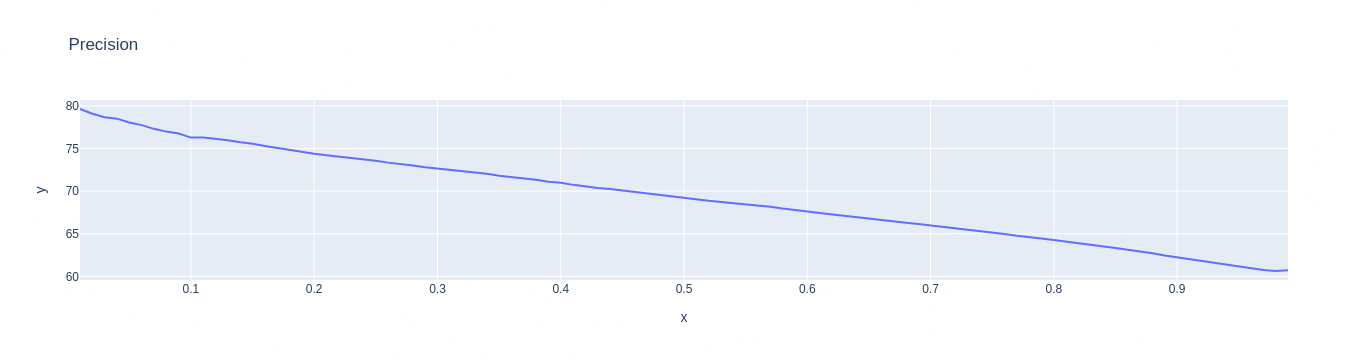

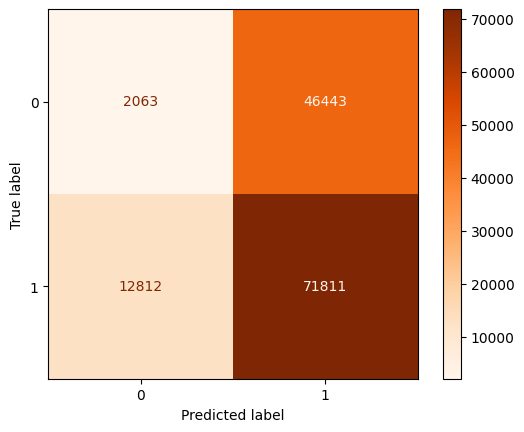

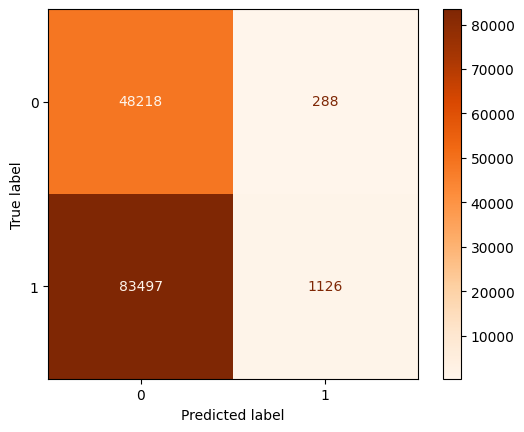

In [15]:
validate_dataset = BitboardDataset("data/games_dataset/bitboards/133129_0.csv", chunk_size=100000, shuffle=False)
validate_dataloader = DataLoader(validate_dataset, batch_size=512)

model = DenseNetwork(1, [768, 768, 1])
model.load_state_dict(torch.load("models/6M/1l/Dense_768_768_1_b512_e50_lr0.01_m0.9_acc81.70", map_location=device))

test_model(model, validate_dataloader)

## 2 hidden layers

Loss: 0.3661465346813202
Acc: 83.38600000000001%
Precision: 80.44758020063941
Recall: 0.8248818755227997


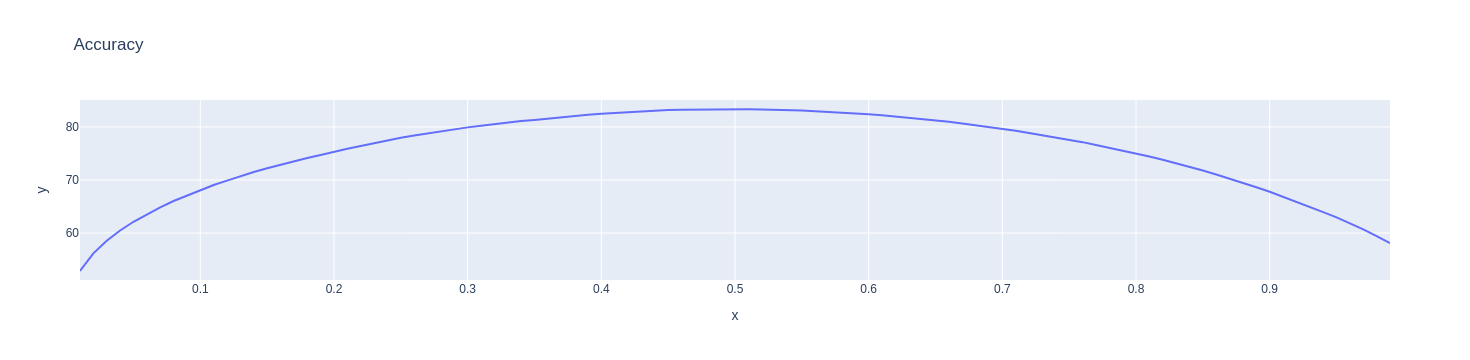

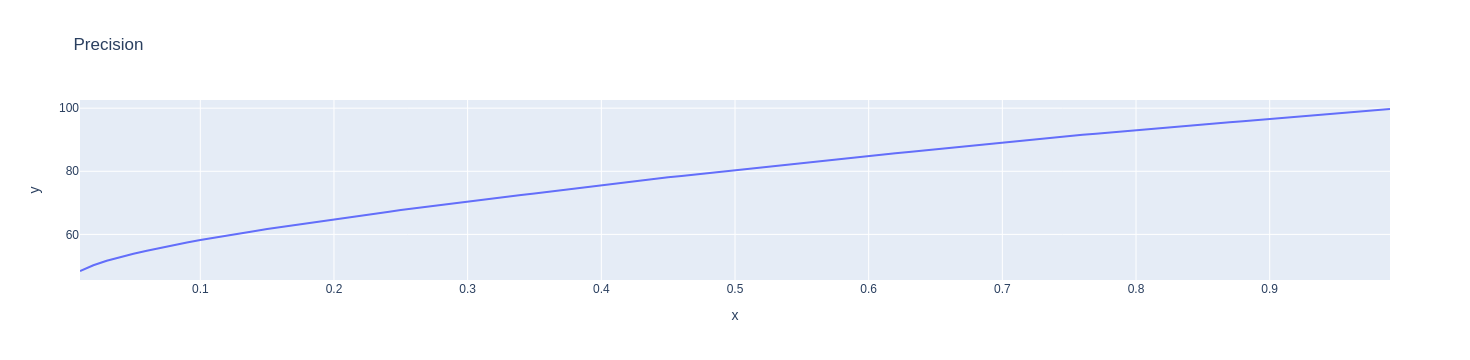

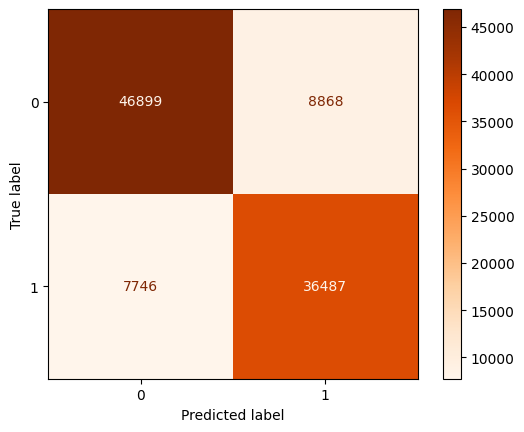

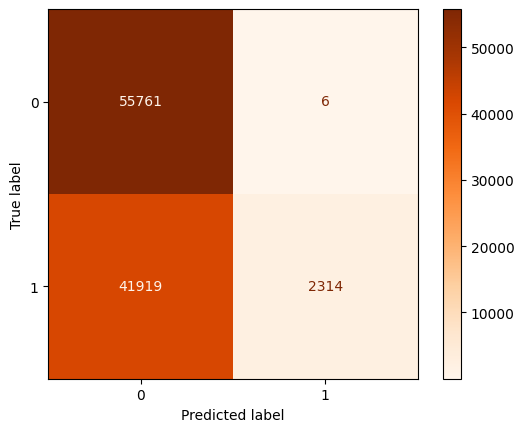

In [18]:
validate_dataset = BitboardDataset("data/eval_dataset/bitboards/100000_1509579_19_24.csv", chunk_size=100000, shuffle=False)
validate_dataloader = DataLoader(validate_dataset, batch_size=512)

model = DenseNetwork(2, [768, 256, 128, 1])
model.load_state_dict(torch.load("models/1M/2l/Dense_768_256_128_1_b512_e50_lr0.01_m0.9_acc83.09", map_location=device))

test_model(model, validate_dataloader)

## 3 hidden Layers

Loss: 0.8332757949829102
Acc: 72.086%
Precision: 75.5032119914347
Recall: 0.8057849890633672


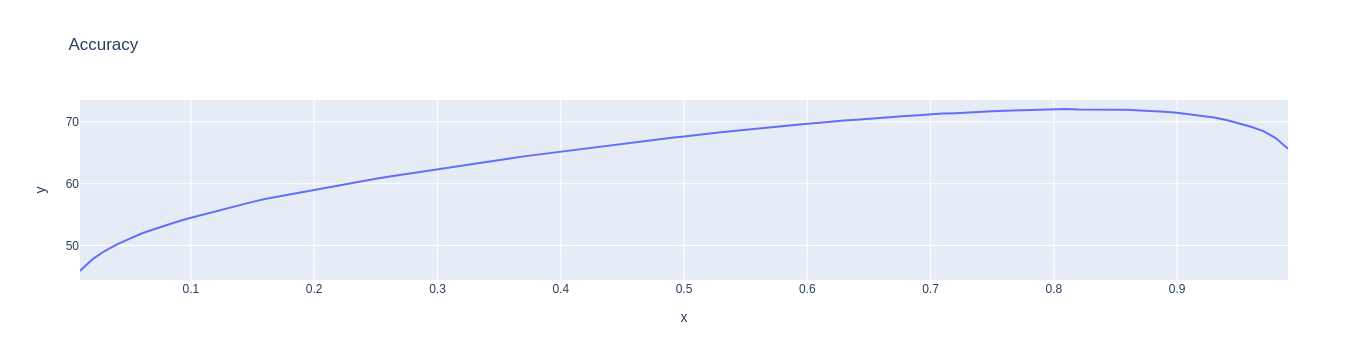

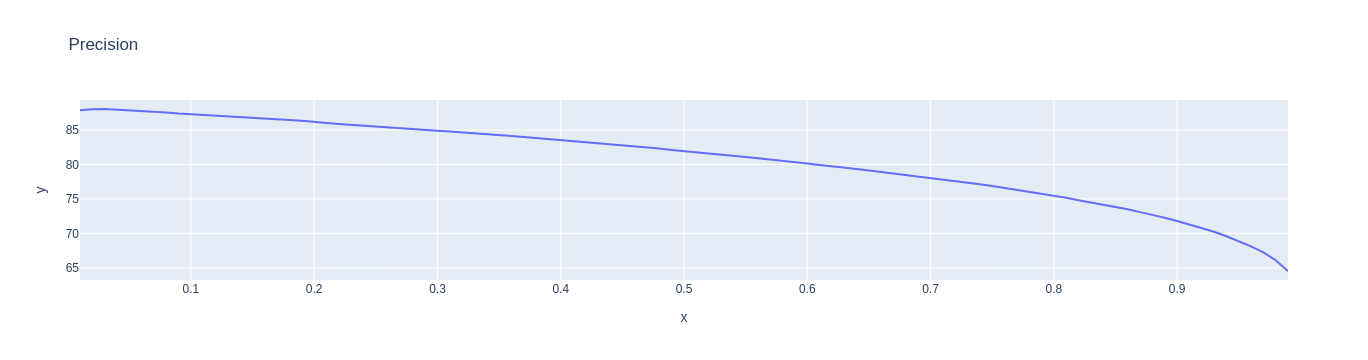

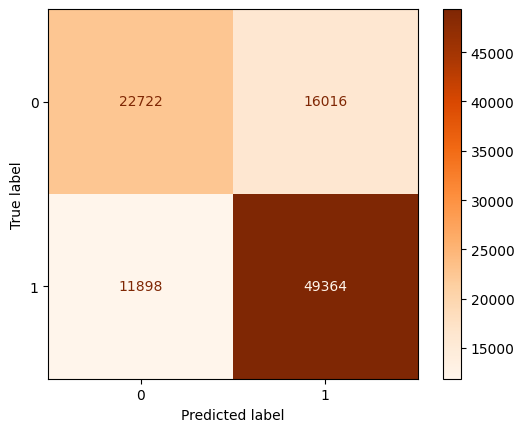

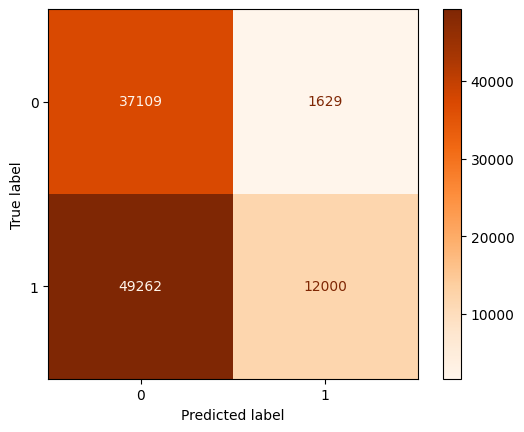

In [14]:
validate_dataset = BitboardDataset("data/eval_dataset/bitboards/100000_1509579_19_24.csv", chunk_size=100000, shuffle=False)
validate_dataloader = DataLoader(validate_dataset, batch_size=512)

model = DenseNetwork(3, [768, 768, 256, 128, 1])
model.load_state_dict(torch.load("models/1M/3l/Dense_768_768_256_128_1_b512_e50_lr0.01_m0.9_acc92.27", map_location=device))

test_model(model, validate_dataloader)

Loss: 0.6217498183250427
Acc: 71.841%
Precision: 73.70222394065674
Recall: 0.8401129574613954


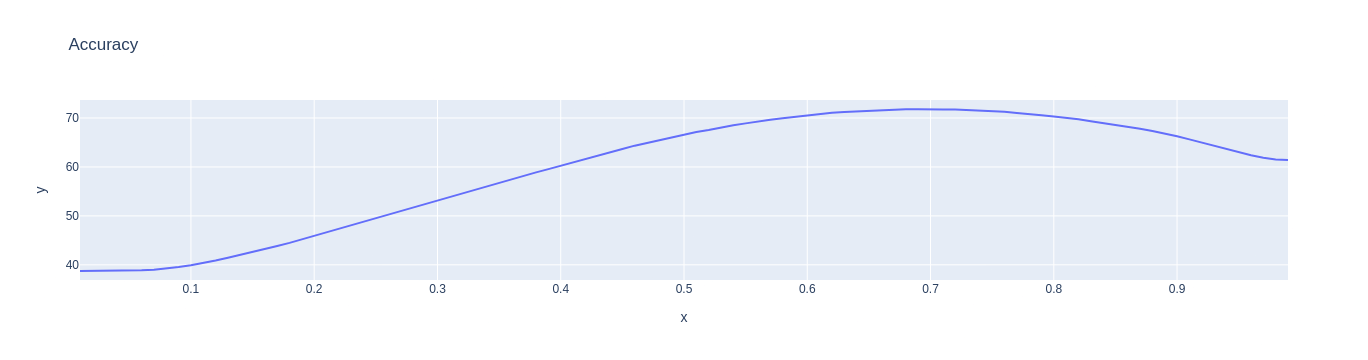

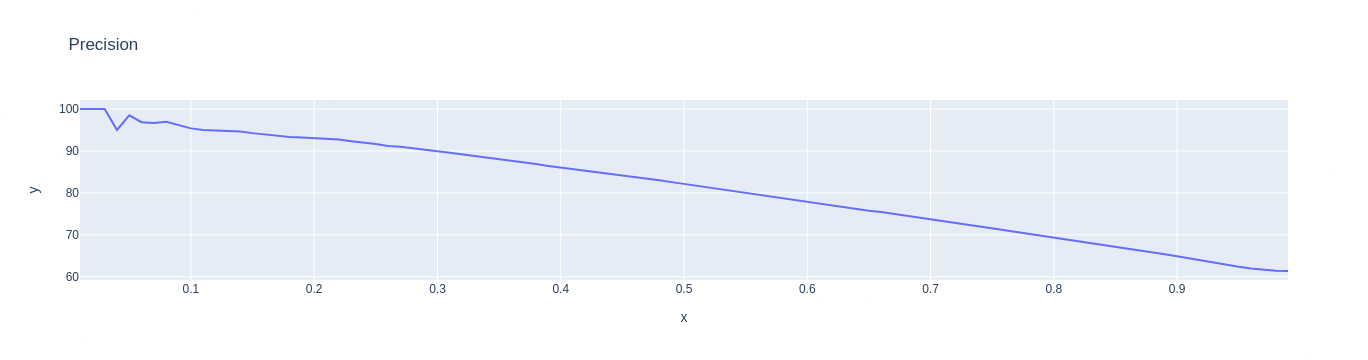

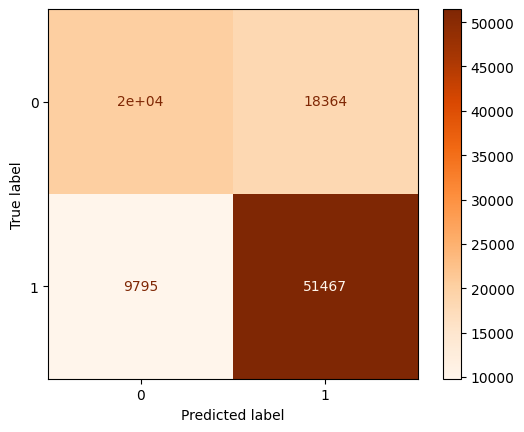

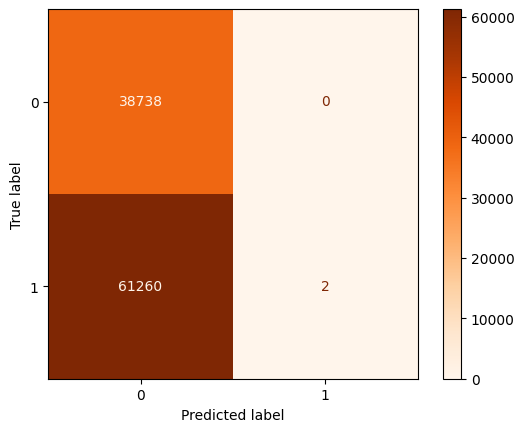

In [12]:
validate_dataset = BitboardDataset("data/eval_dataset/bitboards/100000_1509579_19_24.csv", chunk_size=100000, shuffle=False)
validate_dataloader = DataLoader(validate_dataset, batch_size=512)

model = DenseNetwork(3, [768, 768, 256, 128, 1])
model.load_state_dict(torch.load("models/6M/3l/Dense_768_768_256_128_1_b512_e3_lr0.01_m0.9_acc66.55", map_location=device))

test_model(model, validate_dataloader)

# Conv Net

Loss: 0.6063101887702942
Acc: 72.86200000000001%
Precision: 74.97511563908894
Recall: 0.8360810943162156


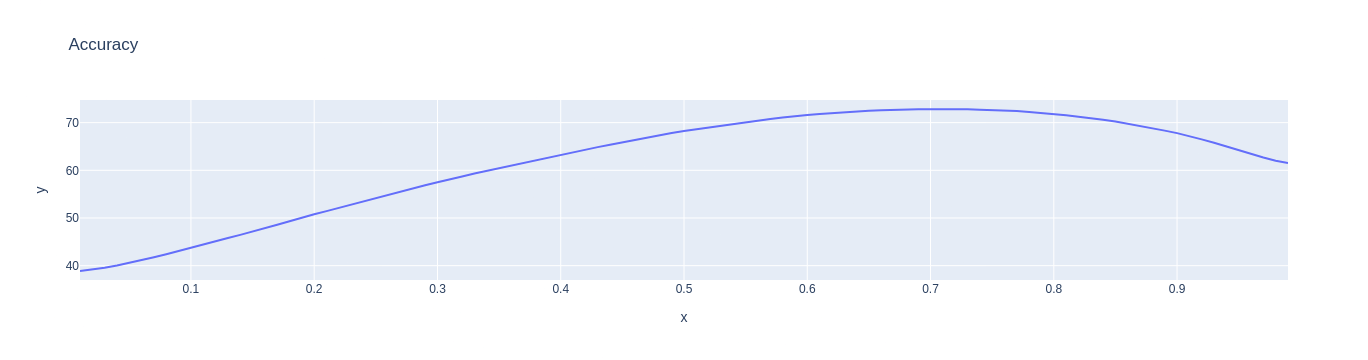

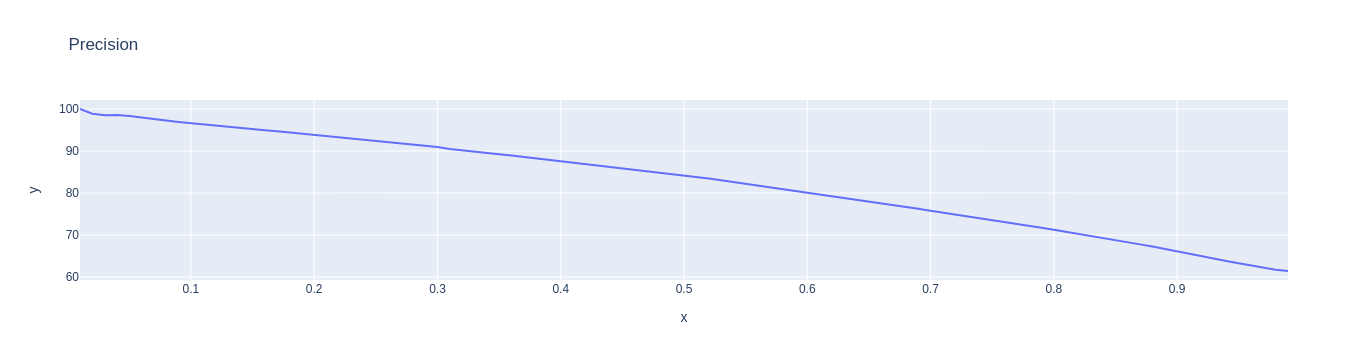

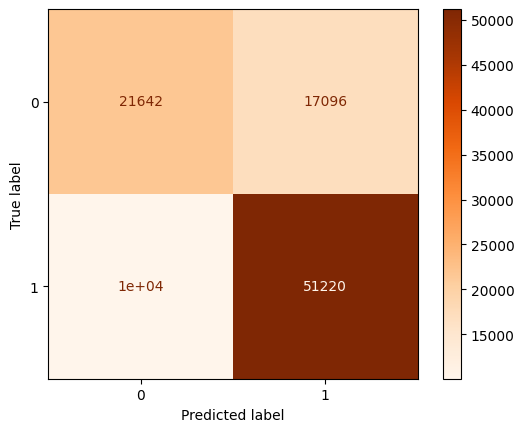

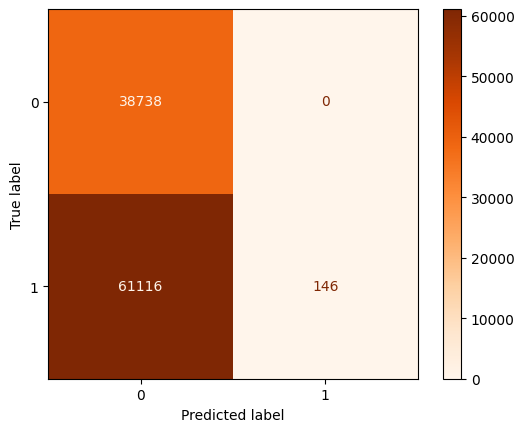

In [17]:
validate_dataset = BitboardDataset("data/eval_dataset/bitboards/100000_1509579_19_24.csv", chunk_size=100000, shuffle=False)
validate_dataloader = DataLoader(validate_dataset, batch_size=512)

model = ConvolutionNetwork()
model.load_state_dict(torch.load("models/6M/3l/ConvNet_b512_e100_lr0.01_m0.9_acc69.97", map_location=device))

test_model(model, validate_dataloader)

# Dataset 

In [6]:
def piece_count_distribution(dataset_path, chunksize=1_000_000):
    results = np.zeros(65, dtype=np.uint32)
    reader = pd.read_csv(dataset_path, usecols=['piece_count'], chunksize=chunksize)
    with tqdm(total=66238679, position=0, leave=True, desc="Positions") as pbar:
        for chunk in reader:
            count = chunk.to_numpy(dtype=np.uint8)
            np.add.at(results, count, 1)
            pbar.update(len(chunk))
            
    return results[1:]

In [7]:
dist = piece_count_distribution('data/eval_dataset/bitboards/66238679_0.csv')

Positions:   0%|          | 0/66238679 [00:00<?, ?it/s]

In [8]:
dist

array([      0,       0,  302376, 2128406, 1424198, 1328703, 1301093,
       1236067, 1340463, 1346121, 1441403, 1461385, 1468816, 1665775,
       1650848, 1934634, 1831281, 2185141, 2006417, 2520767, 2231833,
       3016713, 2457710, 3655442, 2539421, 4349758, 2358367, 4953644,
       1932487, 5126607, 1177874, 3853860,    1497,    1422,    1068,
           693,     579,     548,     451,     418,     260,     253,
           204,     210,     191,     224,     211,     453,     171,
           188,     121,     192,     150,     113,     230,     152,
           131,     125,      96,     135,     119,     179,     135,
           150], dtype=uint32)

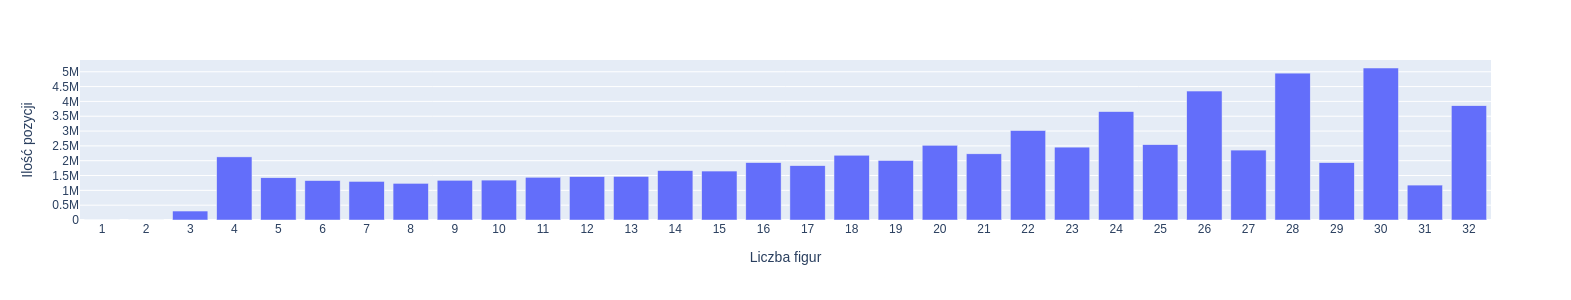

In [9]:
fig = px.bar(x=np.linspace(1, 32, 32), y=dist[:32]/1, width=800, height=300)
fig.update_layout(
    yaxis = dict(
        tickmode='linear',
        dtick=500_000,  # Create grid lines every 250,000
        showgrid=True,
        tickvals=[i for i in range(100_000, max(dist) + 1, 500_000)]  # Label every other grid line    
    ),
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1,
    ),
    xaxis_title="Liczba figur",
    yaxis_title="Ilość pozycji",
)
fig.write_image("pieces_count.svg")
fig.show()

In [16]:
# Create training and testing datasets

def create_final_datasets(name, trainsize):
    testsize = trainsize // 10
    train_splitsize = trainsize // 30
    test_splitsize  = testsize // 30
    
    test_dest   = f"data/eval_dataset/bitboards/testing/{name}_test_{testsize}.csv"
    train_dest   = f"data/eval_dataset/bitboards/training/{name}_train_{trainsize}.csv"
    
    !head -n1 data/eval_dataset/bitboards/66238679_0.csv > {test_dest}
    !head -n1 data/eval_dataset/bitboards/66238679_0.csv > {train_dest}

    for i in range(33):
        source = f"data/eval_dataset/bitboards/div_by_piece_count/dataset_{i}.csv"
        
        !tail -n +2 {source} | shuf > /tmp/shuf_data.csv
        
        !head -n {train_splitsize} /tmp/shuf_data.csv >> {train_dest} 
        !tail -n {test_splitsize} /tmp/shuf_data.csv >> {test_dest} 
    !rm /tmp/shuf_data.csv


In [18]:
create_final_datasets("6M_set1", 6000000)

In [19]:
create_final_datasets("3M_set1", 3000000)

In [20]:
create_final_datasets("900K_set1", 900000)

In [21]:
create_final_datasets("300K_set1", 300000)

In [22]:
create_final_datasets("90K_set1", 90000)

In [23]:
create_final_datasets("3K_set1", 3000)